# Text classification

In [215]:
# Mount google drive 
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/computational_ml_2/computing/neuralNets/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/computational_ml_2/computing/neuralNets/'
/content/drive/MyDrive/computational_ml_2/computing/neuralNets


In [216]:
# Import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Activation, Dense, Dropout, Embedding, 
                          Flatten, Input,  
                          Convolution1D, MaxPooling1D)
from tensorflow.keras.preprocessing import sequence
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import os
import pickle
from w2v import train_word2vec
from tensorflow.keras.models import Sequential

np.random.seed(2)

## Load and preprocess data

In [217]:
embedding_dim = 50
max_sequence_length = 56
max_sequence_length_char = 148

In [218]:
# Load data
dt = pd.read_csv(
    os.path.join("data/data.txt"), sep="\t", header=None,
    names=["text", "labels"]
)

- Not necessary to remove stop words, but perhaps still useful to remove punctuation

In [219]:
def preprocess_text(text):
    text = text.lower()
    text = text.replace('.',' ')
    text = text.replace(',',' ')
    text = text.replace('-',' ')
    text = text.replace('%','')
    text = text.replace(':',' ')
    text = text.replace('(','')
    text = text.replace(')','')
    text = text.replace('\n',' ')
    text = text.replace('[',' ')
    text = text.replace(']',' ')
    text = text.replace('"',' ')
    text = text.replace('  ',' ')
    
    return text

In [220]:
texts = list(map(lambda x: preprocess_text(x), dt.text)) # preprocess
labels = list(dt.labels)

Now we need turn our text samples and labels into tensors that can be fed into a neural network.

In [221]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Word-wise:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens (words).' % len(word_index))

# Character-wise:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(texts)
sequences_char = tokenizer.texts_to_sequences(texts)

char_index = tokenizer.word_index
print('Found %s unique tokens (characters).' % len(char_index))

Found 2071 unique tokens (words).
Found 48 unique tokens (characters).


With the text now tokenized we can use `pad_sequences` to turn the sentences/texts into numerical sequences:

In [226]:
data = pad_sequences(sequences, maxlen=max_sequence_length)
data_char = pad_sequences(sequences_char, maxlen=max_sequence_length_char)

We'll also rearrange the labels slightly:

In [224]:
from keras.utils import to_categorical
labels = to_categorical(np.asarray(labels))

Now both the text data and labels are in an adequate format to be passed to a neural network:

In [227]:
print('Shape of data tensor (words):', data.shape)
print('Shape of data tensor (characters):', data_char.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor (words): (1000, 56)
Shape of data tensor (characters): (1000, 148)
Shape of label tensor: (1000, 2)


## Embeddings

### Pre-trained embeddings - GloVe

Our sample is very small so instead of learning the embeddings from our sample it may be useful to use pre-trained embeddings. For starters we will rely on the smallest global vector embedding available from [GloVe](https://nlp.stanford.edu/projects/glove/), which is still considerable larger than any reasonable embedding we could learn form our sample.

Below we read the 50-$d$ embedding and store dictionary `embeddings_index` containing all words (keys) and their corresponding word vector (values).

In [191]:
GLOVE_DIR = "data/glove/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Now we can use the dictionary of words in our sample created earlier (`word_index`) and match them with their global word vectors if available in `embeddings_index`:

In [192]:
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
no_wv_available = []
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
  else:
    no_wv_available.append(word)

We can see that the the shape of the embedding tensor is in line with the sample as expected. For about 5% of the words in our sample we do not have a corresponding word vector.

In [193]:
print('Shape of embedding tensor:', embedding_matrix.shape)
print('No word vectors available for %i out of %i words.' % (len(no_wv_available), len(word_index)))

Shape of embedding tensor: (2072, 50)
No word vectors available for 101 out of 2071 words.


### Visualizing the word vectors

To get a better understanding of our embedded text, we can register the word vectors in a 2-dimensional subspace and  visualise them.

In [ ]:
from matplotlib import pylab
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)
# get the T-SNE manifold
two_d_embeddings = tsne.fit_transform(embedding_matrix)

In [ ]:
two_d_embeddings

array([[ 84.989975, -41.099045],
       [-79.22622 ,  40.42313 ],
       [-62.7234  ,  35.32548 ],
       ...,
       [ 19.027107,  23.518303],
       [ 20.383322,   4.214771],
       [-46.50964 ,  20.574087]], dtype=float32)

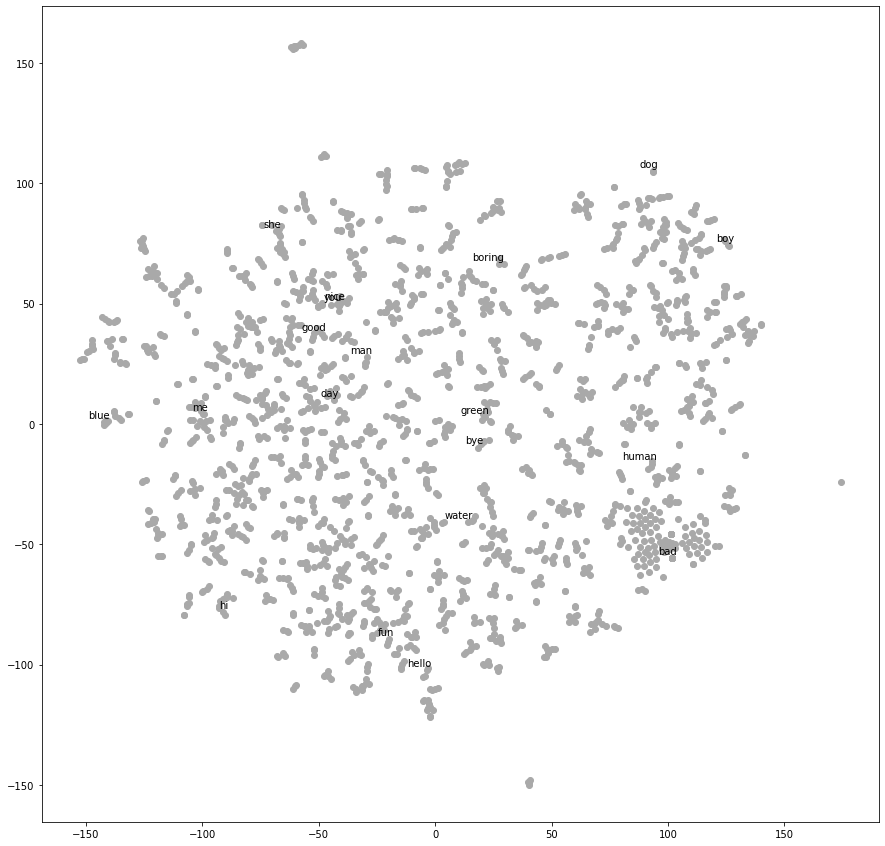

In [ ]:
suggested_words = ['dog', 'dogs', 'wolf',
                   'boy','man','woman','human',
                   'good','fun','nice',
                   'bad', 'boring', 'day',
                   'green', 'grass', 'plant',
                   'blue', 'sky', 'water',
                   'hello', 'bye', 'hi',
                   'you','me','she']
all_words = list(word_index.keys())
selected_words = [i for i in suggested_words if i in all_words]

pylab.figure(figsize=(15,15))
# plot all the embeddings and their corresponding words
for i, label in enumerate(all_words):
  x, y = two_d_embeddings[i,:]
  pylab.scatter(x, y, c='darkgray')   
  if label in selected_words:
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                    ha='right', va='bottom',fontsize=10)
        
pylab.show()

## Word-wise

In [228]:
# Model hyper parameters:
filter_sizes = (3, 4)
num_filters = 150
dropout_prob = (0.25, 0.5)
hidden_dims = 150
# Training parameters:
batch_size = 32
num_epochs = 10
val_split = 0.1
# Word2Vec parameters, see train_word2vec
min_word_count = 1  # Minimum word count                        
context = 10        # Context window size  

#### CNN

In [229]:
# Shuffle data
x = data
vocabulary_inv = ['<PAD/>'] + list(word_index.keys())
y = labels
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices].argmax(axis=1)

In [230]:
from keras.layers import Embedding
# Embedding:
model_variation = 'glove'
embedding_weights = {
    'glove': [embedding_matrix],
    'non-static': train_word2vec(
        x, vocabulary_inv,
        embedding_dim, min_word_count, 
        context
    ),
    'rand': None
}

embedding_layer = Embedding(
    len(word_index)+1,
    embedding_dim,
    weights=embedding_weights[model_variation],
    input_length=max_sequence_length
)

Loading existing Word2Vec model '50features_1minwords_10context'


In [231]:
from tensorflow.keras.layers import concatenate
graph_in = Input(shape=(max_sequence_length,embedding_dim))

convs = [] # list of flattened convolutions to be passed into network
for fsz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in)
    pool = MaxPooling1D(pool_size=2)(conv) # selecting largest value
    flatten = Flatten()(pool) # take output of convolution and flatten it
    convs.append(flatten)
    
if len(filter_sizes)>1:
    out = concatenate(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out)

# main sequential model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(dropout_prob[0], input_shape=(max_sequence_length,embedding_dim)))
model.add(graph)
model.add(Dense(hidden_dims))
model.add(Dropout(dropout_prob[1]))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid')) # link function

In [232]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 2s - loss: 0.8000 - accuracy: 0.5311 - val_loss: 0.7532 - val_accuracy: 0.4300
Epoch 2/10
29/29 - 1s - loss: 0.6233 - accuracy: 0.6600 - val_loss: 0.6937 - val_accuracy: 0.6400
Epoch 3/10
29/29 - 1s - loss: 0.5675 - accuracy: 0.7144 - val_loss: 0.5709 - val_accuracy: 0.6800
Epoch 4/10
29/29 - 1s - loss: 0.4667 - accuracy: 0.7778 - val_loss: 0.5021 - val_accuracy: 0.7200
Epoch 5/10
29/29 - 1s - loss: 0.4085 - accuracy: 0.8167 - val_loss: 0.4774 - val_accuracy: 0.7400
Epoch 6/10
29/29 - 1s - loss: 0.3414 - accuracy: 0.8522 - val_loss: 0.4524 - val_accuracy: 0.7700
Epoch 7/10
29/29 - 1s - loss: 0.2867 - accuracy: 0.8767 - val_loss: 0.5933 - val_accuracy: 0.7200
Epoch 8/10
29/29 - 1s - loss: 0.2394 - accuracy: 0.8989 - val_loss: 0.4614 - val_accuracy: 0.8100
Epoch 9/10
29/29 - 1s - loss: 0.2162 - accuracy: 0.9156 - val_loss: 0.4938 - val_accuracy: 0.7700
Epoch 10/10
29/29 - 1s - loss: 0.1899 - accuracy: 0.9233 - val_loss: 0.4065 - val_accuracy: 0.8600


### RNN

In [ ]:
from tensorflow.keras.layers import LSTM 
# create the model 
embedding_vector_length = 32 
model = Sequential() 
model.add(embedding_layer) 
model.add(LSTM(100)) 
model.add(Flatten()) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 

In [ ]:
# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 4s - loss: 0.5805 - accuracy: 0.7111 - val_loss: 0.4955 - val_accuracy: 0.7200
Epoch 2/10
29/29 - 2s - loss: 0.3348 - accuracy: 0.8756 - val_loss: 0.4462 - val_accuracy: 0.7800
Epoch 3/10
29/29 - 2s - loss: 0.2218 - accuracy: 0.9344 - val_loss: 0.4349 - val_accuracy: 0.8100
Epoch 4/10
29/29 - 2s - loss: 0.1506 - accuracy: 0.9567 - val_loss: 0.4195 - val_accuracy: 0.8400
Epoch 5/10
29/29 - 2s - loss: 0.1207 - accuracy: 0.9644 - val_loss: 0.4490 - val_accuracy: 0.8100
Epoch 6/10
29/29 - 2s - loss: 0.0978 - accuracy: 0.9678 - val_loss: 0.4989 - val_accuracy: 0.8200
Epoch 7/10
29/29 - 2s - loss: 0.0934 - accuracy: 0.9711 - val_loss: 0.4733 - val_accuracy: 0.8200
Epoch 8/10
29/29 - 2s - loss: 0.0591 - accuracy: 0.9856 - val_loss: 0.5104 - val_accuracy: 0.8300
Epoch 9/10
29/29 - 2s - loss: 0.0365 - accuracy: 0.9922 - val_loss: 0.6347 - val_accuracy: 0.8100
Epoch 10/10
29/29 - 2s - loss: 0.0383 - accuracy: 0.9933 - val_loss: 0.5138 - val_accuracy: 0.8100


## Character-wise

### CNN

In [ ]:
# Shuffle data
x = data_char
vocabulary_inv = ['<PAD/>'] + list(char_index.keys())
y = labels
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices].argmax(axis=1)

In [ ]:
# Embedding:
model_variation = 'rand'
embedding_weights = {
    'non-static': train_word2vec(
        x, vocabulary_inv,
        embedding_dim, min_word_count, 
        context
    ),
    'rand': None
}

embedding_layer = Embedding(
    len(char_index)+1,
    embedding_dim,
    weights=embedding_weights[model_variation],
    input_length=max_sequence_length_char
)

Loading existing Word2Vec model '50features_1minwords_10context'


In [ ]:
graph_in = Input(shape=(max_sequence_length_char,embedding_dim))

convs = [] # list of flattened convolutions to be passed into network
for fsz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in)
    pool = MaxPooling1D(pool_size=2)(conv) # selecting largest value
    flatten = Flatten()(pool) # take output of convolution and flatten it
    convs.append(flatten)
    
if len(filter_sizes)>1:
    out = concatenate(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out)

# main sequential model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(dropout_prob[0], input_shape=(max_sequence_length_char,embedding_dim)))
model.add(graph)
model.add(Dense(hidden_dims))
model.add(Dropout(dropout_prob[1]))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid')) # link function

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 3s - loss: 0.7364 - accuracy: 0.5011 - val_loss: 0.6854 - val_accuracy: 0.5800
Epoch 2/10
29/29 - 2s - loss: 0.6870 - accuracy: 0.5422 - val_loss: 0.6796 - val_accuracy: 0.6100
Epoch 3/10
29/29 - 3s - loss: 0.6613 - accuracy: 0.6289 - val_loss: 0.6852 - val_accuracy: 0.5500
Epoch 4/10
29/29 - 2s - loss: 0.5979 - accuracy: 0.6978 - val_loss: 0.6954 - val_accuracy: 0.5800
Epoch 5/10
29/29 - 2s - loss: 0.5405 - accuracy: 0.7311 - val_loss: 0.7118 - val_accuracy: 0.5400
Epoch 6/10
29/29 - 2s - loss: 0.4700 - accuracy: 0.7911 - val_loss: 0.6290 - val_accuracy: 0.6800
Epoch 7/10
29/29 - 3s - loss: 0.4118 - accuracy: 0.8222 - val_loss: 0.6984 - val_accuracy: 0.6400
Epoch 8/10
29/29 - 2s - loss: 0.3585 - accuracy: 0.8467 - val_loss: 0.6803 - val_accuracy: 0.6400
Epoch 9/10
29/29 - 2s - loss: 0.2848 - accuracy: 0.9000 - val_loss: 0.8296 - val_accuracy: 0.6100
Epoch 10/10
29/29 - 2s - loss: 0.2555 - accuracy: 0.8989 - val_loss: 0.7917 - val_accuracy: 0.6500


### RNN

In [239]:
# create the model 
embedding_vector_length = 32 
model = Sequential() 
model.add(embedding_layer) 
model.add(LSTM(100)) 
model.add(Flatten()) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 

In [240]:
# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 5s - loss: 0.6852 - accuracy: 0.5967 - val_loss: 0.6707 - val_accuracy: 0.6000
Epoch 2/10
29/29 - 4s - loss: 0.6643 - accuracy: 0.6278 - val_loss: 0.6673 - val_accuracy: 0.6000
Epoch 3/10
29/29 - 4s - loss: 0.6450 - accuracy: 0.6322 - val_loss: 0.6502 - val_accuracy: 0.6200
Epoch 4/10
29/29 - 4s - loss: 0.6350 - accuracy: 0.6256 - val_loss: 0.6614 - val_accuracy: 0.6000
Epoch 5/10
29/29 - 4s - loss: 0.6407 - accuracy: 0.6456 - val_loss: 0.6734 - val_accuracy: 0.5600
Epoch 6/10
29/29 - 4s - loss: 0.6519 - accuracy: 0.6122 - val_loss: 0.6642 - val_accuracy: 0.5700
Epoch 7/10
29/29 - 4s - loss: 0.6381 - accuracy: 0.6300 - val_loss: 0.6621 - val_accuracy: 0.6300
Epoch 8/10
29/29 - 4s - loss: 0.6309 - accuracy: 0.6300 - val_loss: 0.6570 - val_accuracy: 0.6100
Epoch 9/10
29/29 - 4s - loss: 0.6195 - accuracy: 0.6533 - val_loss: 0.6565 - val_accuracy: 0.5800
Epoch 10/10
29/29 - 4s - loss: 0.6121 - accuracy: 0.6522 - val_loss: 0.6436 - val_accuracy: 0.6100
